In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from arch.bootstrap import MCS

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
#广告数
narms = 5 
#context
d = 5              
steps = 2000
repeats = 100
np.random.seed(42) 

# arm对应一个隐藏线性权重向量 θ_a
true_thetas = [np.random.normal(0, 1, d) for _ in range(narms)]

In [ ]:
class CAB_EpsGreedy:
    def __init__(self, narms, d, epsilon):
        self.narms = narms
        self.d = d
        self.epsilon = epsilon

        self.X = [np.zeros((0, d)) for _ in range(narms)]
        self.y = [np.array([]) for _ in range(narms)]
        self.theta = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.narms)
        preds = [np.dot(context, self.theta[a]) for a in range(self.narms)]
        return np.argmax(preds)

    def update(self, context, arm, reward):
        self.X[arm] = np.vstack([self.X[arm], context])
        self.y[arm] = np.append(self.y[arm], reward)

        X_arm = self.X[arm]
        y_arm = self.y[arm]
        if X_arm.shape[0] >= self.d:
            reg = 1e-4 * np.eye(self.d)
            XtX = X_arm.T @ X_arm + reg
            Xty = X_arm.T @ y_arm
            self.theta[arm] = np.linalg.solve(XtX, Xty)



class CAB_LinUCB:
    def __init__(self, narms, d, alpha):
        self.narms = narms
        self.d = d
        self.alpha = alpha

        self.A = [np.identity(d) for _ in range(narms)]
        self.b = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        p = np.zeros(self.narms)
        for a in range(self.narms):
            A_inv = np.linalg.inv(self.A[a])
            theta_a = A_inv @ self.b[a]
            p[a] = context @ theta_a + self.alpha * np.sqrt(context @ A_inv @ context)
        return np.argmax(p)

    def update(self, context, arm, reward):
        x = context.reshape(-1, 1)
        self.A[arm] += x @ x.T
        self.b[arm] += reward * context



class CAB_ThompsonSampling:
    def __init__(self, narms, d):
        self.narms = narms
        self.d = d
        self.X = [np.zeros((0, d)) for _ in range(narms)]
        self.y = [np.array([]) for _ in range(narms)]
        self.theta_samples = [np.zeros(d) for _ in range(narms)]

    def select_arm(self, context):
        preds = []
        for a in range(self.narms):
            if self.X[a].shape[0] < self.d:
                preds.append(np.random.rand())
                continue
            XTX = self.X[a].T @ self.X[a] + 1e-4 * np.eye(self.d)
            XTy = self.X[a].T @ self.y[a]
            theta_mean = np.linalg.solve(XTX, XTy)
            cov = np.linalg.inv(XTX)
            theta_sample = np.random.multivariate_normal(theta_mean, cov)
            preds.append(np.dot(context, theta_sample))
        return np.argmax(preds)

    def update(self, context, arm, reward):
        self.X[arm] = np.vstack([self.X[arm], context])
        self.y[arm] = np.append(self.y[arm], reward)



In [15]:
def run_experiment_cab(policy_class, true_thetas, steps, d, **kwargs):
    narms = len(true_thetas)
    bandit = policy_class(narms, d, **kwargs)
    rewards = np.zeros(steps)

    for t in range(steps):
        context = np.random.normal(0, 1, d)
        arm = bandit.select_arm(context)
        click_prob = sigmoid(np.dot(context, true_thetas[arm]))
        reward = np.random.binomial(1, click_prob)
        bandit.update(context, arm, reward)
        rewards[t] = reward

    return rewards


In [ ]:
policy_configs = {
    "Eps=0.0": (CAB_EpsGreedy, {"epsilon": 0.0}),
    "Eps=0.1": (CAB_EpsGreedy, {"epsilon": 0.1}),
    "Eps=0.3": (CAB_EpsGreedy, {"epsilon": 0.3}),
    "Eps=0.5": (CAB_EpsGreedy, {"epsilon": 0.5}),
    "LinUCB": (CAB_LinUCB, {"alpha": 0.5}),
    "TS": (CAB_ThompsonSampling, {}),
}


cumulative_rewards = {}

for name, (policy_class, params) in policy_configs.items():
    reward_list = []
    for _ in range(repeats):
        rewards = run_experiment_cab(policy_class, true_thetas, steps, d, **params)
        total_reward = rewards.sum()
        reward_list.append(total_reward)
    cumulative_rewards[name] = reward_list


In [ ]:
'''MCS'''
policy_names = list(cumulative_rewards.keys())
reward_matrix = []

for i in range(repeats):
    row = []
    for name in policy_names:
        row.append(cumulative_rewards[name][i])
    reward_matrix.append(row)

reward_matrix = np.array(reward_matrix)
loss_matrix = -reward_matrix


In [ ]:
mcs = MCS(loss_matrix, size=0.05, reps=1000, block_size=1)
mcs.compute()

included_indices = mcs.included
included_policies = [policy_names[i] for i in included_indices]

print("MCS 95% policy set: ")
print(included_policies)


MCS 95% 策略置信集：
['LinUCB']


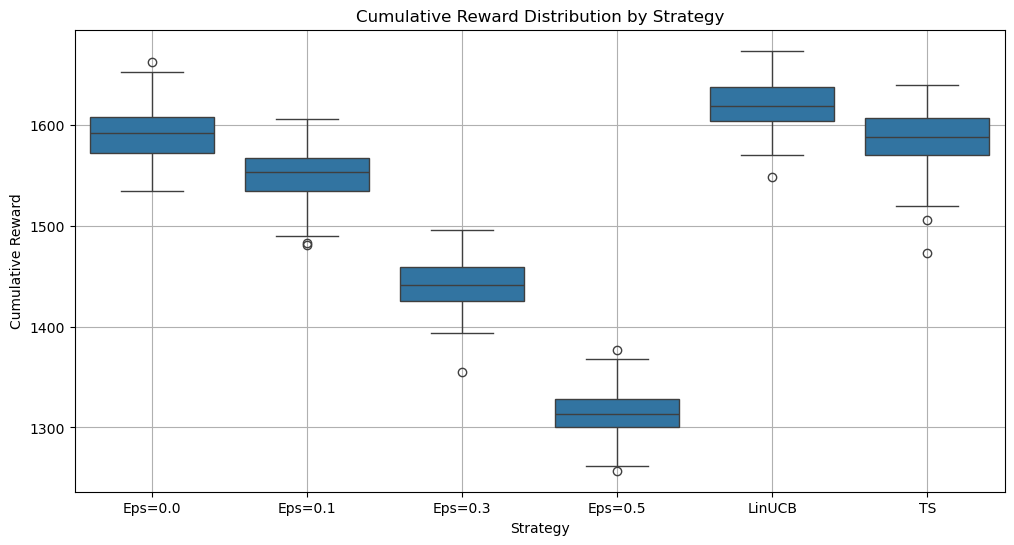

In [19]:
df = pd.DataFrame(cumulative_rewards)
df_melted = df.melt(var_name="Strategy", value_name="Cumulative Reward")

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x="Strategy", y="Cumulative Reward")
plt.title("Cumulative Reward Distribution by Strategy")
plt.grid(True)
plt.show()

